# discrete offline analysis to optimize settings

In [1]:
# need to do filtering to get the filtered EMG signals from raw EMG signals 
def filter_signal(raw_signal, mean_flag = True):
    """
    generic function that filters the raw signal
    Args:
        raw_signal [num of sensors x number of samples ]
    Returns:
        filtered_signal [num of sensors x number of samples] if mean_flag is False otherwise; [num of sensors x 1]
    """

    # mean_flag = False, we want all the data, not the averaged data
    filtered_signal = filt_delinearize(raw_signal, mean_flag=mean_flag)

    return filtered_signal
    
# high and low pass filtering with FIR filters
def filt_fir(emg_raw, mean_flag = True):
    """
    inputs: 
    emg_raw: the raw EMG signal to perform the RMS filtering on
    mean_flag[bool]: True, final output will be taken average, otherwise, not

    output:
    emg_filt: filtered EMG signal
    """
    fs = 2048
    taps_lp = firwin(numtaps=31,cutoff=40,fs=fs,pass_zero='lowpass')
    taps_hp = firwin(numtaps=31,cutoff=40,fs=fs,pass_zero='highpass')

    emg_hp = lfilter(taps_hp, 1.0, emg_raw)
    emg_rect = abs(emg_hp)
    emg_lp = lfilter(taps_lp,1.0,emg_rect)
    emg_filt = np.mean(abs(emg_lp),axis=1)  

    return emg_filt

# delinearize filter
def filt_delinearize(emg_raw, mean_flag = True):
    """
    inputs:
    emg_raw: the raw EMG signal to perform the RMS filtering on
    output:
    emg_filt: filtered EMG signal
    """
    # emg_raw = abs(np.asarray(emg_raw))
    wN = emg_raw.shape[1]
    # DETREND FIRST HALF OF DATA BEFORE TAKING AVERAGE (TODO: ask Momona about this)
    data1 = detrend(emg_raw[:,:int(wN/2)], axis=1,type='linear')
    data2 = detrend(emg_raw[:,int(wN/2):], axis=1,type='linear')
    datanew = np.concatenate((data1,data2),axis=1)
    emg_filt = np.mean(abs(datanew),axis=1)
    return emg_filt

# set up gradient of cost:
# d(c_L2(D))/d(D) = 2*(DF + HV - V+)*F.T + 2*alphaD*D
def gradient_cost_l2(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder # TODO: we now have a timeseries component - consult Sam
    H: 2 x 2 state transition matrix
    ''' 
    Nd = 2
    Ne = 64
    Nt = learning_batch

    # TODO: add depth (time) to D
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]

    return ((2 * (D@F + H@Vminus - Vplus) @ F.T / (Nd*Nt) 
        + 2 * alphaD * D / (Nd*Ne)).flatten())

# set up gradient of cost:
# d(c_L2(D))/d(D) = 2*(DF + HV - V+)*F.T + 2*alphaD*D
def gradient_cost_l2_discrete(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder # TODO: we now have a timeseries component - consult Sam
    H: 2 x 2 state transition matrix
    ''' 
    Nd = 2
    Ne = 64
    Nt = learning_batch

    # TODO: add depth (time) to D
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    v_unbounded = D@F
    theta = np.arctan2(v_unbounded[1],v_unbounded[0])
    v_actual = np.asarray([10*np.cos(theta),10*np.sin(theta)])
    return ((2 * (v_actual + H@Vminus - Vplus) @ F.T / (Nd*Nt) 
        + 2 * alphaD * D / (Nd*Ne)).flatten())
        
# set up the cost function: 
# c_L2 = (||DF + HV - V+||_2)^2 + alphaD*(||D||_2)^2 + alphaF*(||F||_2)^2
def cost_l2_discrete(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    ''' 
    Nd = 2
    Ne = 64 # default = 64
    Nt = learning_batch
    # TODO: add depth (time) to D
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    v_unbounded = D@F
    theta = np.arctan2(v_unbounded[1],v_unbounded[0])
    v_actual = np.asarray([10*np.cos(theta),10*np.sin(theta)])
    e = ( np.sum( (v_actual + H@Vminus - Vplus)**2 ) / (Nd*Nt) 
            + alphaD * np.sum( D**2 ) / (Nd*Ne)
            + alphaF * np.sum( F**2 ) / (Ne*Nt) )
    return e

# set up the cost function: 
# c_L2 = (||DF + HV - V+||_2)^2 + alphaD*(||D||_2)^2 + alphaF*(||F||_2)^2
def cost_l2(F, D, H, V, alphaF=1e-2, alphaD=1e-2):
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    ''' 
    Nd = 2
    Ne = 64 # default = 64
    Nt = learning_batch
    # TODO: add depth (time) to D
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]

    e = ( np.sum( (D @ F + H@Vminus - Vplus)**2 ) / (Nd*Nt) 
            + alphaD * np.sum( D**2 ) / (Nd*Ne)
            + alphaF * np.sum( F**2 ) / (Ne*Nt) )
    return e

def estimate_decoder(F, H, V):
    return (V[:,1:]-H@V[:,:-1])@np.linalg.pinv(F)

In [4]:
import h5py as h5
import aopy 
import pandas as pd
import os
import numpy as np
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from scipy.signal import detrend, firwin, freqz, lfilter
from sklearn.model_selection import train_test_split,ShuffleSplit
import copy as copy
from scipy.optimize import minimize,least_squares
import copy
from itertools import permutations

In [5]:
print(os.getcwd())

C:\Users\kdmen\Desktop\Research\personalization-privacy-risk


In [4]:
filename = "weiner_discrete_task_data_META_S155834.h5"

# if you want to check to make sure file exists
# from os.path import exists
# file_exists = exists(filename)
# print(file_exists)

weiner_task_data, weiner_config = aopy.data.load_bmi3d_hdf_table("", filename, 'weiner')

# extract data and save to pandas dataframe

In [113]:
weiner_task_data, weiner_config = aopy.data.load_bmi3d_hdf_table('',filename, 'weiner')
f = weiner_task_data
print(f.dtype.names) # get the names of the fields

timestamp = f['timestamp']
decoded_cursor_position = f['decoded_cursor_position']
decoded_velocity = f['decoded_velocity']
weiner_filter_w = f['weiner_filter_w']
weiner_filter_h = f['weiner_filter_h']
alpha = f['alpha']
raw_emg = f['raw_emg']
filtered_emg = f['filtered_emg']
reference = f['reference']
cued_target_position = f['cued_target_position']

# change target positions to angle
cued_angles = np.arctan2(cued_target_position[:,1], cued_target_position[:,0])
cued_angles_classes = (cued_angles*2/np.pi+2.001).astype(int) # need to add that 0.001 so all the numbers can round down during int conversion

('timestamp', 'decoded_cursor_position', 'decoded_velocity', 'weiner_filter_w', 'weiner_filter_h', 'alpha', 'subject_id', 'decoder_id', 'raw_emg', 'filtered_emg', 'reference', 'cued_target_position')


Text(0, 0.5, 'voltages that are int idk')

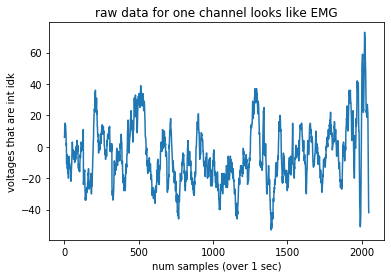

In [114]:
plt.plot(raw_emg[1,10,:])
plt.title('raw data for one channel looks like EMG')
plt.xlabel('num samples (over 1 sec)')
plt.ylabel('voltages that are int idk')

# preprocessing

## filter data 

raw EMG size is 50 trials x 64 channels x 2048 timepoints (1 second of data)

filtered EMG size is 50 trials x 64 channels x 60 timepoints (1 second of data)

- input (``raw_emg``): raw EMG (1 second sample)

- output (``filtered_signals``): downsampled and filtered EMG signals at 60 Hz for 1 second

In [115]:
# FILTER SIGNALS TO APPROPRIATE SIZE

win_downsample = int(np.floor(raw_emg.shape[2]/2048*60))
filtered_signals = np.zeros((50, 64,  win_downsample))
window = np.floor(2048/60)
for trial in range(1,raw_emg.shape[0]):
    for ix in range(win_downsample - 1):
        # window the signal
        window_signal = raw_emg[trial,:,int(ix*window):int((ix+1)*window)]
        # print(window_signal[0,0])
        # filter the windowed signal
        filtered_signal = filter_signal(window_signal)
        filtered_signals[trial,:,ix] = np.squeeze(filtered_signal)
        # print(filtered_signal)

Text(0, 0.5, 'voltages that are int idk')

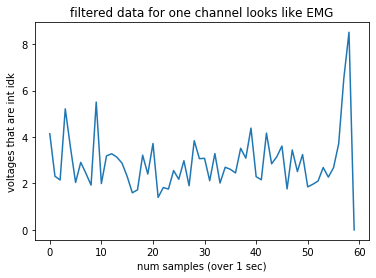

In [116]:
plt.plot(filtered_signals[1,10,:])
plt.title('filtered data for one channel looks like EMG')
plt.xlabel('num samples (over 1 sec)')
plt.ylabel('voltages that are int idk')

# let's try running some simulations

``cued_target_position``: 50 trials x x and y pos

we are ignoring the first trial because the human signals are 0 for some reason :/ 

In [196]:
# constrain p - do we want to include radius distance when we update the new decoder?
def constrain_p_actual(p):
    '''
    input: decoded velocity (2,)
    output: constrained decoded velocity (2,)
    '''
    # if np.linalg.norm(p) >= 10:
    theta = np.arctan2(p[1],p[0])
    return [10*np.cos(theta),10*np.sin(theta)]
    # else:
    #     return p

# integrate velocity 
def compute_position(v):
    '''
    input v: velocity (2,T)
    output: position (2,)
    '''
    return np.sum(v,axis=1)
    
# given decoder, what is the new position?
def output_new_decoder(s,D,p_intended):
    '''
    s: (64 x (60 timepoints x learning batch size))
    D: (2 x 64) previous D computed or random
    p_intended: (2 x 60 timepoints x learning batch size)
    '''
    # take first trial, random decoder, and do target classification
    v = D@s # actual decoded velocity (2,60)

    # integrate decoded velocities into positions
    p = []
    for ix in range(v.shape[1]):
        p.append(np.sum(v[:,:ix],axis=1))
    p = np.asarray(p).T # actual decoded position (2,60)

    # want error between intended and actual velocity but need to constrain actual velocity to target radius
    p_constrained = np.asarray([constrain_p_actual(p_) for p_ in p.T]).T # constrained, (2,60)
    # compute error between intended and actual position and take derivative to get intended velocity
    v_intended = p_intended - p_constrained # (2,60)
    return v_intended,p_constrained

# given decoder, what is the new position?
def output_new_decoder_constant_intention(s,D,p_intended):
    '''
    s: (64 x (60 timepoints x learning batch size))
    D: (2 x 64) previous D computed or random
    p_intended: (2 x 60 timepoints x learning batch size)
    '''
    # take first trial, random decoder, and do target classification
    v = D@s # actual decoded velocity (2,60)

    # integrate decoded velocities into positions
    p = []
    for ix in range(v.shape[1]):
        p.append(np.sum(v[:,:ix],axis=1))
    p = np.asarray(p).T # actual decoded position (2,60)

    # want error between intended and actual velocity but need to constrain actual velocity to target radius
    p_constrained = np.asarray([constrain_p_actual(p_) for p_ in p.T]).T # constrained, (2,60)
    # compute error between intended and actual position and take derivative to get intended velocity
    v_intended = p_intended # (2,60) # divide by 60 was removed
    return v_intended,p_constrained

In [3]:
import numpy as np

num_targets = 4
TARGET_LOCATION_RADIUS = 10
thetas = 2*np.pi/num_targets*np.arange(0,num_targets) # convert number of targets to angles
target_positions = TARGET_LOCATION_RADIUS*np.asarray([np.cos(thetas),np.sin(thetas)]).T
print(target_positions.shape)
print(target_positions)

(4, 2)
[[ 1.0000000e+01  0.0000000e+00]
 [ 6.1232340e-16  1.0000000e+01]
 [-1.0000000e+01  1.2246468e-15]
 [-1.8369702e-15 -1.0000000e+01]]


In [ ]:
def classify(decoded_cursor_velocity, print_indx = False):
    
    # pick the smallest distance diff
    dist_diffs = np.linalg.norm((decoded_cursor_velocity.T - target_positions),
                                axis = 1) # this should be an array
    
    min_dist_diffs = np.argmin(dist_diffs)

    classified_target = target_positions[min_dist_diffs,:]#[:, None]

    # target_postions is a global variabe
    return classified_target

def classification_accuracy(p_target,p_classify): 
    '''
    inputs: 
        p_target: target positions (trials x 2)
        p_classify: classified positions (trials x 2)
    output:
        success_rate: classification accuracy (number)
    '''
    target_pos_diff = p_classify - p_target
    target_pos_diff_norm = np.linalg.norm(target_pos_diff, axis = 1)
    target_pos_count = sum(target_pos_diff_norm < 0.01)
    success_rate = target_pos_count / len(target_pos_diff_norm)
    return success_rate

In [197]:
# Added 2 new parameters
def simulation(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2,display_info=False,num_iters=False):
    p_classify = []
    accuracy_temp = []
    num_updates = int(np.floor((filtered_signals.shape[0]-1)/learning_batch)) # how many times can we update decoder based on learning batch    

    # RANDOMIZE DATASET
    randomized_integers = np.random.permutation(range(0,cued_target_position.shape[0]))
    filtered_signals_randomized = filtered_signals[randomized_integers]
    cued_target_position_randomized = cued_target_position[randomized_integers]
    # batches the trials into each of the update batch
    for ix in range(num_updates):
        s = np.hstack([x for x in filtered_signals_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:,:]])# stack s (64 x (60 timepoints x learning batch size))
        p_intended = np.hstack([np.tile(x[:,np.newaxis],60) for x in cued_target_position_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:]]) # stack p_intended (2 x 60 timepoints x learning batch size)
        v_intended,p_constrained = output_new_decoder(s,D[-1],p_intended)

        # CLASSIFY CURRENT DECODER ACCURACY
        v_actual = D[-1]@s
        for trial in range(learning_batch):
            v_trial = v_actual[:,int(trial*60):int((trial+1)*60)] # velocities for each trials (2,60)
            p_final = np.sum(v_trial,axis=1)[:,np.newaxis] # final position after integration (2,)
            p_classify.append(classify(p_final))
        
        # UPDATE DECODER
        u = copy.deepcopy(s) # u is the person's signal s (64 CHANNELS X TIMEPOINTS)
        q = copy.deepcopy(v_intended) # use cued positions as velocity vectors for updating decoder should be 2 x num_trials

        # emg_windows against intended_targets (trial specific cued target)
        F = copy.deepcopy(u[:,:-1]) # note: truncate F for estimate_decoder
        V = copy.deepcopy(q)

        # initial decoder estimate for gradient descent
        D0 = np.random.rand(2,64)

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        if num_iters is False:
            out = minimize(lambda D: cost_l2(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2(F,D,H,V), options={'disp': display_info})
        else:
            out = minimize(lambda D: cost_l2(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2(F,D,H,V), options={'disp': display_info, 'maxiter':num_iters})
        
        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        D.append(W_new)

        # COMPUTE CLASSIFICATION ACURACY 
        p_target = (cued_target_position[randomized_integers])[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:] # obtain target
        accuracy_temp.append(classification_accuracy(p_target,p_classify[-learning_batch:]))

    p_classify = np.asarray(p_classify)
    return accuracy_temp,D,p_constrained

In [198]:
def simulation_constant_intent(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2):
    p_classify = []
    accuracy_temp = []
    num_updates = int(np.floor((filtered_signals.shape[0]-1)/learning_batch)) # how many times can we update decoder based on learning batch    

    # RANDOMIZE DATASET
    randomized_integers = np.random.permutation(range(0,cued_target_position.shape[0]))
    filtered_signals_randomized = filtered_signals[randomized_integers]
    cued_target_position_randomized = cued_target_position[randomized_integers]
    for ix in range(num_updates):
        s = np.hstack([x for x in filtered_signals_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:,:]])# stack s (64 x (60 timepoints x learning batch size))
        p_intended = np.hstack([np.tile(x[:,np.newaxis],60) for x in cued_target_position_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:]]) # stack p_intended (2 x 60 timepoints x learning batch size)
        v_intended,p_constrained = output_new_decoder_constant_intention(s,D[-1],p_intended)

        # CLASSIFY CURRENT DECODER ACCURACY
        v_actual = D[-1]@s
        for trial in range(learning_batch):
            v_trial = v_actual[:,int(trial*60):int((trial+1)*60)] # velocities for each trials (2,60)
            p_final = np.sum(v_trial,axis=1)[:,np.newaxis] # final position after integration (2,)
            p_classify.append(classify(p_final))
        
        # UPDATE DECODER
        u = copy.deepcopy(s) # u is the person's signal s (64 CHANNELS X TIMEPOINTS)
        q = copy.deepcopy(v_intended) # use cued positions as velocity vectors for updating decoder should be 2 x num_trials

        # emg_windows against intended_targets (trial specific cued target)
        F = copy.deepcopy(u[:,:-1]) # note: truncate F for estimate_decoder
        V = copy.deepcopy(q)

        # initial decoder estimate for gradient descent
        D0 = np.random.rand(2,64)

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        out = minimize(lambda D: cost_l2(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2(F,D,H,V), options={'disp': False})

        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        D.append(W_new)

        # COMPUTE CLASSIFICATION ACURACY 
        p_target = (cued_target_position[randomized_integers])[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:] # obtain target
        accuracy_temp.append(classification_accuracy(p_target,p_classify[-learning_batch:]))

    p_classify = np.asarray(p_classify)
    return accuracy_temp,D,p_constrained

In [199]:
def simulation_constant_intent_bounded(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2):
    p_classify = []
    accuracy_temp = []
    num_updates = int(np.floor((filtered_signals.shape[0]-1)/learning_batch)) # how many times can we update decoder based on learning batch    

    # RANDOMIZE DATASET
    randomized_integers = np.random.permutation(range(0,cued_target_position.shape[0]))
    filtered_signals_randomized = filtered_signals[randomized_integers]
    cued_target_position_randomized = cued_target_position[randomized_integers]
    for ix in range(num_updates):
        s = np.hstack([x for x in filtered_signals_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:,:]])# stack s (64 x (60 timepoints x learning batch size))
        p_intended = np.hstack([np.tile(x[:,np.newaxis],60) for x in cued_target_position_randomized[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:]]) # stack p_intended (2 x 60 timepoints x learning batch size)
        v_intended,p_constrained = output_new_decoder_constant_intention(s,D[-1],p_intended)

        # CLASSIFY CURRENT DECODER ACCURACY
        v_actual = D[-1]@s
        for trial in range(learning_batch):
            v_trial = v_actual[:,int(trial*60):int((trial+1)*60)] # velocities for each trials (2,60)
            p_final = np.sum(v_trial,axis=1)[:,np.newaxis] # final position after integration (2,)
            p_classify.append(classify(p_final))
        
        # UPDATE DECODER
        u = copy.deepcopy(s) # u is the person's signal s (64 CHANNELS X TIMEPOINTS)
        q = copy.deepcopy(v_intended) # use cued positions as velocity vectors for updating decoder should be 2 x num_trials

        # emg_windows against intended_targets (trial specific cued target)
        F = copy.deepcopy(u[:,:-1]) # note: truncate F for estimate_decoder
        V = copy.deepcopy(q)

        # initial decoder estimate for gradient descent
        D0 = np.random.rand(2,64)

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        out = minimize(lambda D: cost_l2_discrete(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2_discrete(F,D,H,V), options={'disp': False})

        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        D.append(W_new)

        # COMPUTE CLASSIFICATION ACURACY 
        p_target = (cued_target_position[randomized_integers])[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:] # obtain target
        accuracy_temp.append(classification_accuracy(p_target,p_classify[-learning_batch:]))

    p_classify = np.asarray(p_classify)
    return accuracy_temp,D,p_constrained

In [200]:
def simulation_bounded_pos(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2):
    p_classify = []
    accuracy_temp = []
    num_updates = int(np.floor((filtered_signals.shape[0]-1)/learning_batch)) # how many times can we update decoder based on learning batch    

    # RANDOMIZE DATASET
    randomized_integers = np.random.permutation(range(1,cued_target_position.shape[0]))
    filtered_signals_randomized = filtered_signals[randomized_integers]
    cued_target_position_randomized = cued_target_position[randomized_integers]
    for ix in range(num_updates):
        s = np.hstack([x for x in filtered_signals_randomized[int(ix*learning_batch):int((ix+1)*learning_batch),:,:]])# stack s (64 x (60 timepoints x learning batch size))
        p_intended = np.hstack([np.tile(x[:,np.newaxis],60) for x in cued_target_position_randomized[int(ix*learning_batch):int((ix+1)*learning_batch),:]]) # stack p_intended (2 x 60 timepoints x learning batch size)
        v_intended,p_constrained = output_new_decoder(s,D[-1],p_intended)

        # CLASSIFY CURRENT DECODER ACCURACY
        v_actual = D[-1]@s
        for trial in range(learning_batch):
            v_trial = v_actual[:,int(trial*60):int((trial+1)*60)] # velocities for each trials (2,60)
            p_final = np.sum(v_trial,axis=1)[:,np.newaxis] # final position after integration (2,)
            p_classify.append(classify(p_final))
        
        # UPDATE DECODER
        u = copy.deepcopy(s) # u is the person's signal s (64 CHANNELS X TIMEPOINTS)
        q = copy.deepcopy(v_intended) # use cued positions as velocity vectors for updating decoder should be 2 x num_trials

        # emg_windows against intended_targets (trial specific cued target)
        F = copy.deepcopy(u[:,:-1]) # note: truncate F for estimate_decoder
        V = copy.deepcopy(q)

        # initial decoder estimate for gradient descent
        D0 = np.random.rand(2,64)

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        out = minimize(lambda D: cost_l2_discrete(F,D,H,V), D0, method='BFGS', jac = lambda D: gradient_cost_l2_discrete(F,D,H,V), options={'disp': False})

        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        D.append(W_new)

        # COMPUTE CLASSIFICATION ACURACY 
        p_target = (cued_target_position[randomized_integers])[int(ix*learning_batch+1):int((ix+1)*learning_batch+1),:] # obtain target
        accuracy_temp.append(classification_accuracy(p_target,p_classify[-learning_batch:]))

    p_classify = np.asarray(p_classify)
    return accuracy_temp,D,p_constrained

In [212]:
learning_batch = 8
alpha = .95 # higher alpha means more old decoder (slower update)
alphaF=1e-1
alphaD = 1e-1
# create random decoder 
D_0 = np.random.rand(2,64)
D = []
D_constant = []
D_bounded = []
D_constant_bounded = []
D.append(D_0)
D_constant.append(D_0)
D_bounded.append(D_0)
D_constant_bounded.append(D_0)
accuracy = []
accuracy_constant = []
accuracy_bounded = []
accuracy_constant_bounded = []

for ix in range(10000):
    accuracy_constant_,D_constant,p_constrained_constant = simulation_constant_intent(D_constant,learning_batch,alpha,alphaF=alphaF,alphaD=alphaD)
    accuracy_constant.extend(accuracy_constant_)
    accuracy_,D,p_constrained = simulation(D,learning_batch,alpha,alphaF=alphaF,alphaD=alphaD)    
    accuracy.extend(accuracy_)
    accuracy_bounded_,D_bounded,p_bounded = simulation_bounded_pos(D_bounded,learning_batch,alpha,alphaF=alphaF,alphaD=alphaD)  
    accuracy_bounded.extend(accuracy_bounded_)
    accuracy_constant_bounded_,D_constant_bounded,p_constant_bounded = simulation_constant_intent_bounded(D_constant_bounded,learning_batch,alpha,alphaF=alphaF,alphaD=alphaD)
    accuracy_constant_bounded.extend(accuracy_constant_bounded_)

KeyboardInterrupt: 

# get cumulative accuracy

going with constant target -- ``simulation_constant_intent``

In [213]:
def plot_cum_accuracy(accuracy,title):
    cumulative_accuracy = []

    for ix in range(len(accuracy)):
        average_accuracy = np.mean(np.asarray(accuracy[0:ix]))
        cumulative_accuracy.append(average_accuracy)

    plt.plot(cumulative_accuracy)
    plt.title(title)
    plt.ylabel('percentage correct')
    plt.xlabel('decoder update number')


C:\Users\aolab\.conda\envs\py369_env\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\aolab\.conda\envs\py369_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


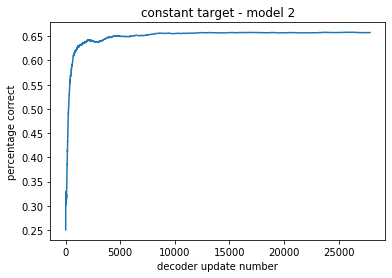

In [214]:
plot_cum_accuracy(accuracy_constant,"constant target - model 2")

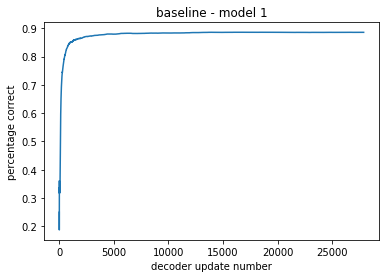

In [215]:
plot_cum_accuracy(accuracy,"baseline - model 1")

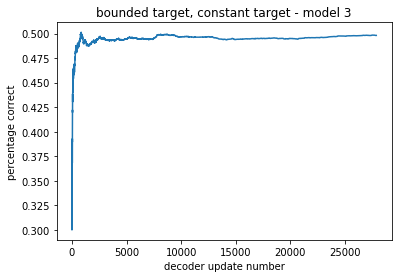

In [216]:
plot_cum_accuracy(accuracy_constant_bounded,"bounded target, constant target - model 3")

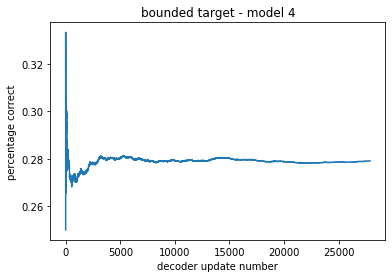

In [217]:
plot_cum_accuracy(accuracy_bounded,"bounded target - model 4")